In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-mix2.txt')
data.head()

,Y
0,9.44
1,9.77
2,11.56
3,10.07
4,10.13


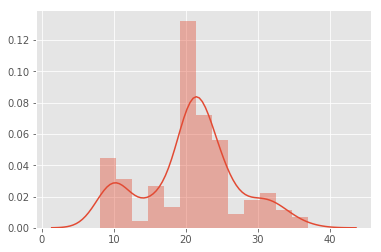

In [3]:
sns.distplot(data)

In [4]:
stan_model = """

data {
  int N;
  int K;
  vector[N] Y;
}

parameters {
  simplex[K] a;
  ordered[K] mu;
  vector<lower=0>[K] sigma;
  real<lower=0> s_mu;
}

model {
  mu ~ normal(mean(Y), s_mu);
  sigma ~ gamma(1.5, 1.0);
  for (n in 1:N){
    vector[K] lp;
    for (k in 1:K){
      lp[k] = log(a[k]) + normal_lpdf(Y[n] | mu[k], sigma[k]);
    }
    target += log_sum_exp(lp);
  }
}

"""

In [5]:
stan_model = """

functions {
  real normal_mixture_lpdf(real Y, int K, vector a, vector mu, vector sigma){
    vector[K] lp;
    for (k in 1:K){
      lp[k] = log(a[k]) + normal_lpdf(Y | mu[k], sigma[k]);
    }
    return log_sum_exp(lp);
  }
}

data {
  int N;
  int K;
  vector[N] Y;
}

parameters {
  simplex[K] a;
  ordered[K] mu;
  vector<lower=0>[K] sigma;
  real<lower=0> s_mu;
}

model {
  mu ~ normal(mean(Y), s_mu);
  sigma ~ gamma(1.5, 1.0);
  for (n in 1:N){
    Y[n] ~ normal_mixture(K, a, mu, sigma);
  }
}
"""

In [6]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9dd2e142277db981560d8f46884529c1 NOW.


In [7]:
stan_data = {}
stan_data['N'] = data.shape[0]
stan_data['K'] = 5
stan_data['Y'] = data['Y']

In [8]:
fit = sm.sampling(stan_data)

In [9]:
fit

Inference for Stan model: anon_model_9dd2e142277db981560d8f46884529c1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]       0.17  5.8e-4   0.03   0.12   0.15   0.17   0.19   0.22   2121   1.01
a[2]       0.14    0.05   0.08   0.06   0.09   0.11   0.17   0.32      3   2.18
a[3]       0.32  5.3e-3   0.09   0.14   0.26   0.31   0.37   0.49    260   1.03
a[4]       0.24    0.04   0.11   0.04   0.17   0.25   0.32   0.45      9   1.19
a[5]       0.14    0.02   0.05   0.04   0.11   0.14   0.16   0.23      8   1.18
mu[1]     10.01  3.4e-3   0.18   9.66   9.89   10.0  10.12  10.35   2743    1.0
mu[2]     17.33    1.46   2.11  15.45  15.93  16.22  20.39  21.03      2    4.7
mu[3]     21.08    0.28   0.52  20.65   20.8   20.9  21.09  22.76      4   1.51
mu[4]      23.6    0.07   1.08  22.19  23.02   23.5   24.0   25.3    266   1.03
mu[5]     3

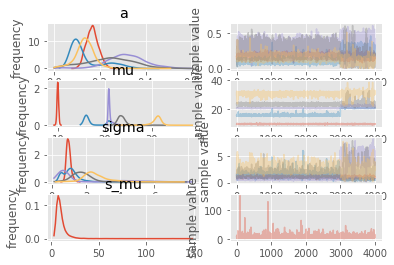

In [10]:
fig = fit.plot()